# Multi agent Frozen Lake env
An implmentation of a 2 agents version of gym's FrozenLake
We can customize the map (with `S` the starting points of the two agents, `F` the floor cells, `H` the holes and `G` the target)

In [2]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import time
import random
import sys
import pygame
from collections import defaultdict
import os
import colorsys

### Define the map

In [3]:
MAPS = {
    "4x4": [
        "SFFF",
        "FHHS",
        "FFFH",
        "HFFG"
    ],
    "5x5": [
        "SFFFH",
        "HFFHF",
        "FFFFH",
        "HFHFF",
        "SFHFG"
    ],
    "6x6": [
        "SFFFHF",
        "HFFHFF",
        "FFHFHF",
        "HFFFHH",
        "FFHFHF",
        "SFFFFG"
    ],
    "7x7": [
        "SFFFFFH",
        "HFFHFHF",
        "FFHFFFH",
        "HFFFHFF",
        "FHFHFHF",
        "HFFHFHS",
        "GFFFFFH"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "SHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
}

In [4]:
def createMap(num_agent, size, map_name=None, seed=None):
    """
    Generate a random FrozenLake map with a feasible path for each agent to the goal.

    Args:
        num_agent (int): Number of agents (starting positions).
        size (int): Grid size (size x size).
        seed (int): Random seed for reproducibility.

    Returns:
        list: A list of strings representing the generated map.
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    if map_name is not None:
        return MAPS[map_name]
    
    # Define elements
    FLOOR, HOLE, START, GOAL = 'F', 'H', 'S', 'G'
    
    # Step 1: Create an empty grid filled with 'F' (frozen floor)
    grid = np.full((size, size), FLOOR)

    # Step 2: Place the goal randomly
    goal_pos = (random.randint(0, size - 1), random.randint(0, size - 1))
    grid[goal_pos] = GOAL

    # Step 3: Randomly place start positions, ensuring they are unique and not on the goal
    start_positions = set()
    while len(start_positions) < num_agent:
        start_pos = (random.randint(0, size - 1), random.randint(0, size - 1))
        if start_pos != goal_pos:
            start_positions.add(start_pos)

    for start_pos in start_positions:
        grid[start_pos] = START

    # Step 4: Randomly place holes
    num_holes = max(1, int(0.2 * size * size))  # 20% of the grid is holes
    hole_positions = set()
    
    while len(hole_positions) < num_holes:
        hole_pos = (random.randint(0, size - 1), random.randint(0, size - 1))
        if hole_pos != goal_pos and hole_pos not in start_positions:
            hole_positions.add(hole_pos)
    
    for hole_pos in hole_positions:
        grid[hole_pos] = HOLE

    # Step 5: Check if all agents can reach the goal
    def is_path_exists(start, goal, grid):
        """Check if there's a valid path using BFS."""
        rows, cols = grid.shape
        queue = [start]
        visited = set()

        while queue:
            x, y = queue.pop(0)
            if (x, y) == goal:
                return True
            visited.add((x, y))

            # Possible moves (Left, Down, Right, Up)
            for dx, dy in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < rows and 0 <= ny < cols and (nx, ny) not in visited:
                    if grid[nx, ny] != HOLE:
                        queue.append((nx, ny))

        return False

    # Ensure every agent can reach the goal
    for start in start_positions:
        if not is_path_exists(start, goal_pos, grid):
            return createMap(num_agent, size, seed + 1 if seed is not None else None)  # Retry with a different seed

    # Convert to list of strings
    return ["".join(row) for row in grid]

### Environment

In [6]:
class MultiAgentFrozenLake(gym.Env):
    def __init__(self, map_, max_steps=100, num_agents=2):
        # Load the map
        # self.desc = np.asarray(MAPS[map_name], dtype='c')
        self.desc = np.asarray(map_, dtype='c')
        self.nrow, self.ncol = self.desc.shape
        self.original_desc = self.desc.copy()  # Keep original for reference
        self.num_agents = num_agents
        
        # Define action and observation spaces
        # Create a tuple of Discrete(4) for each agent
        self.action_space = spaces.Tuple(tuple(spaces.Discrete(4) for _ in range(num_agents)))
        
        # State space: (agent1_row, agent1_col, agent2_row, agent2_col, ..., agentN_row, agentN_col)
        # Create a tuple of Discrete spaces for each agent's position
        self.observation_space = spaces.Tuple(
            tuple(spaces.Discrete(self.nrow) for _ in range(num_agents)) +  # rows
            tuple(spaces.Discrete(self.ncol) for _ in range(num_agents))    # columns
        )
        
        self.max_steps = max_steps 
        self.np_random = np.random.RandomState()
        
        # Need to import colorsys for agent color generation
        import colorsys
        self.colorsys = colorsys
        
        self.reset()
        
    def reset(self, seed=None):
        if seed is not None:
            self.np_random = np.random.RandomState(seed)
        
        self.desc = self.original_desc.copy()
        start_positions = np.argwhere(self.desc == b'S')
        goal_positions = np.argwhere(self.desc == b'G')
        
        # Initialize agent positions
        self.agent_positions = []
        
        # If we have enough start positions for all agents
        if len(start_positions) >= self.num_agents:
            for i in range(self.num_agents):
                self.agent_positions.append(start_positions[i % len(start_positions)])
        else:
            # If not enough start positions, place all agents at the first start position
            for i in range(self.num_agents):
                self.agent_positions.append(start_positions[0].copy())
        
        # Initialize goal positions
        if len(goal_positions) > 0:
            self.goal_pos = goal_positions[0]  # Use the first goal for simplicity
        else:
            raise ValueError("No goal position found on the map")
        
        self.steps = 0
        self.agents_goal_steps = [None] * self.num_agents
        
        # Flatten the state: [agent1_row, agent1_col, agent2_row, agent2_col, ...]
        self.state = tuple(pos for agent_pos in self.agent_positions for pos in agent_pos)
        
        # Initialize last actions for all agents (default to UP)
        self.last_actions = [3] * self.num_agents
        
        return self.state, {}
    
    def step(self, actions):
        self.steps += 1
        
        # Ensure actions is a list or tuple with the right length
        if isinstance(actions, (int, np.integer)):  # Handle single agent case
            actions = [actions]
        elif not isinstance(actions, (list, tuple, np.ndarray)) or len(actions) != self.num_agents:
            raise ValueError(f"Expected actions to be a list/tuple of length {self.num_agents}, got {actions}")
        
        # Store last actions for rendering
        self.last_actions = list(actions)
        
        # On first step, convert all 'S' to 'F' after agents have moved
        if self.steps == 1:
            start_positions = np.argwhere(self.desc == b'S')
            for pos in start_positions:
                self.desc[pos[0], pos[1]] = b'F'
        
        # Move all agents
        for i, action in enumerate(actions):
            if i < len(self.agent_positions):  # Ensure we don't go out of bounds
                self.agent_positions[i] = self._move_agent(self.agent_positions[i], action)
        
        # Check if agents have reached goals
        dones = []
        for i, agent_pos in enumerate(self.agent_positions):
            done = np.array_equal(agent_pos, self.goal_pos)
            dones.append(done)
            if done and self.agents_goal_steps[i] is None:
                self.agents_goal_steps[i] = self.steps
        
        # Update state
        self.state = tuple(pos for agent_pos in self.agent_positions for pos in agent_pos)
        
        # Check if any agent has fallen into a hole
        fallen_agents = []
        for i, agent_pos in enumerate(self.agent_positions):
            if self.desc[agent_pos[0], agent_pos[1]] == b'H':
                fallen_agents.append(i)
        
        # Determine overall done condition
        done = (all(dones) or self.steps >= self.max_steps or len(fallen_agents) > 0)
        
        # Calculate reward
        if len(fallen_agents) > 0:
            reward = -5.0  # Immediate failure if any agent falls
        elif all(dones):
            # Check if all agents reached the goal at the same time
            goal_steps = [step for step in self.agents_goal_steps if step is not None]
            if len(goal_steps) == self.num_agents and len(set(goal_steps)) == 1:
                reward = 1.0  # Full reward if they all arrive together
            else:
                reward = 0.5  # Partial reward if they arrive at different times
        elif any(dones):
            reward = -0.2  # Penalize reaching the goal alone
        else:
            reward = -0.001  # Small penalty to encourage movement
        
        truncated = self.steps >= self.max_steps
        
        return self.state, reward, done, truncated, {}
    
    def _move_agent(self, position, action):
        # Get new position
        new_position = position.copy()
        
        # 0: LEFT, 1: DOWN, 2: RIGHT, 3: UP
        if action == 0:  # LEFT
            new_position[1] = max(0, position[1] - 1)
        elif action == 1:  # DOWN
            new_position[0] = min(self.nrow - 1, position[0] + 1)
        elif action == 2:  # RIGHT
            new_position[1] = min(self.ncol - 1, position[1] + 1)
        elif action == 3:  # UP
            new_position[0] = max(0, position[0] - 1)
        
        # Check if new position is a hole or valid
        if self.desc[new_position[0], new_position[1]] != b'H':
            return new_position
        else:
            # If it's a hole, agent falls in
            return new_position

    def render_pygame(self, screen_size=400):
        """Render the environment using pygame with the original gym images"""
        # Initialize pygame if not already done
        if not hasattr(self, 'pygame_initialized') or not self.pygame_initialized:
            pygame.init()
            self.pygame_initialized = True
            self.screen = pygame.display.set_mode((screen_size, screen_size))
            pygame.display.set_caption(f"Multi-Agent Frozen Lake ({self.num_agents} agents)")
            self.cell_size = screen_size // max(self.nrow, self.ncol)
            self.running = True  # Flag to control pygame loop
            
            # Load images from gym repository
            img_dir = "img/"
            self.images = {
                'F': pygame.image.load(img_dir + "ice.png"),
                'H': pygame.image.load(img_dir + "hole.png"),
                'G': pygame.image.load(img_dir + "ice.png"),  # Use ice as background for goal
                'S': pygame.image.load(img_dir + "stool.png")
            }
            
            # Load goal sprite separately to overlay on ice
            self.goal_sprite = pygame.image.load(img_dir + "goal.png")
            self.goal_sprite = pygame.transform.scale(self.goal_sprite, (self.cell_size, self.cell_size))
            
            # Load agent images for different directions
            self.agent_images = {
                'up': pygame.image.load(img_dir + "elf_up.png"),
                'down': pygame.image.load(img_dir + "elf_down.png"),
                'left': pygame.image.load(img_dir + "elf_left.png"),
                'right': pygame.image.load(img_dir + "elf_right.png")
            }
            
            # Resize images to fit the cell size
            for key in self.images:
                self.images[key] = pygame.transform.scale(self.images[key], (self.cell_size, self.cell_size))
            
            for key in self.agent_images:
                self.agent_images[key] = pygame.transform.scale(self.agent_images[key], (self.cell_size, self.cell_size))
            
            # Create red-tinted version for collision
            self.collision_images = {}
            
            for key, img in self.agent_images.items():
                # Create red-tinted version for collision
                self.collision_images[key] = img.copy()
                red_surface = pygame.Surface(img.get_size(), pygame.SRCALPHA)
                red_surface.fill((255, 0, 0, 100))  # Red tint
                self.collision_images[key].blit(red_surface, (0, 0), special_flags=pygame.BLEND_RGBA_ADD)
            
            # Define agent indicator colors - generate a unique color for each agent
            self.agent_colors = []
            for i in range(self.num_agents):
                # Generate a unique color based on the agent index
                hue = i / max(1, self.num_agents)
                rgb = self.colorsys.hsv_to_rgb(hue, 1.0, 1.0)
                self.agent_colors.append((int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255)))
        
        # Don't render if pygame has been closed
        if not hasattr(self, 'running') or not self.running:
            return
        
        # Clear screen
        self.screen.fill((0, 0, 0))
        
        # Draw grid
        for i in range(self.nrow):
            for j in range(self.ncol):
                tile_char = self.desc[i, j].decode('utf-8')
                rect = pygame.Rect(j * self.cell_size, i * self.cell_size,
                                self.cell_size, self.cell_size)
                # Draw tile
                self.screen.blit(self.images[tile_char], rect)
                
                # Overlay goal sprite on ice if this is the goal position
                if tile_char == 'G':
                    self.screen.blit(self.goal_sprite, rect)
        
        # Draw grid lines
        grid_color = (50, 50, 50)  # Dark gray
        for i in range(self.nrow + 1):
            pygame.draw.line(self.screen, grid_color, 
                            (0, i * self.cell_size), 
                            (self.ncol * self.cell_size, i * self.cell_size), 2)
        for j in range(self.ncol + 1):
            pygame.draw.line(self.screen, grid_color, 
                            (j * self.cell_size, 0), 
                            (j * self.cell_size, self.nrow * self.cell_size), 2)
        
        # Map actions to directions for agent images
        direction_map = {0: 'left', 1: 'down', 2: 'right', 3: 'up'}
        
        # Check for collisions (where 2 or more agents occupy the same cell)
        # Create a dictionary to track cell occupancy
        cell_occupancy = {}
        for i, agent_pos in enumerate(self.agent_positions):
            pos_tuple = tuple(agent_pos)
            if pos_tuple in cell_occupancy:
                cell_occupancy[pos_tuple].append(i)
            else:
                cell_occupancy[pos_tuple] = [i]
        
        # Draw agents
        for i, agent_pos in enumerate(self.agent_positions):
            pos_tuple = tuple(agent_pos)
            agent_rect = pygame.Rect(agent_pos[1] * self.cell_size, 
                                   agent_pos[0] * self.cell_size,
                                   self.cell_size, self.cell_size)
            
            # Make sure we have a valid action index
            action_idx = min(self.last_actions[i], 3) if i < len(self.last_actions) else 3
            
            # Check if this agent is colliding with others
            is_collision = len(cell_occupancy[pos_tuple]) > 1
            
            if is_collision:
                # Use red-tinted image for collisions
                collision_img = self.collision_images[direction_map[action_idx]]
                self.screen.blit(collision_img, agent_rect)
                
                # Draw indicators for all colliding agents
                colliding_agents = cell_occupancy[pos_tuple]
                for idx, colliding_agent_idx in enumerate(colliding_agents):
                    # Position indicators at different corners
                    indicator_size = max(4, int(self.cell_size / 8))
                    
                    # Calculate position based on index (up to 4 agents per cell)
                    corner_idx = idx % 4
                    if corner_idx == 0:  # Top-left
                        pos = (agent_rect.left + indicator_size, agent_rect.top + indicator_size)
                    elif corner_idx == 1:  # Top-right
                        pos = (agent_rect.right - indicator_size, agent_rect.top + indicator_size)
                    elif corner_idx == 2:  # Bottom-left
                        pos = (agent_rect.left + indicator_size, agent_rect.bottom - indicator_size)
                    else:  # Bottom-right
                        pos = (agent_rect.right - indicator_size, agent_rect.bottom - indicator_size)
                    
                    # Draw the indicator
                    if colliding_agent_idx < len(self.agent_colors):
                        pygame.draw.circle(self.screen, self.agent_colors[colliding_agent_idx], pos, indicator_size)
            else:
                # Draw agent normally
                agent_img = self.agent_images[direction_map[action_idx]]
                self.screen.blit(agent_img, agent_rect)
                
                # Draw a small indicator for agent identification
                indicator_size = max(4, int(self.cell_size / 8))
                pygame.draw.circle(self.screen, self.agent_colors[i], 
                                (agent_rect.left + indicator_size, agent_rect.top + indicator_size), 
                                indicator_size)
        
        # Update display
        pygame.display.flip()
        
        # Process events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.running = False
                pygame.quit()
                return
            
    def close(self):
        """Properly close the pygame window"""
        if hasattr(self, 'pygame_initialized') and self.pygame_initialized:
            self.running = False
            pygame.quit()
            self.pygame_initialized = False

### Random policy

In [7]:
class RandomPolicy:
    def __init__(self, action_size=4):
        self.action_size = action_size
    
    def select_action(self, state):
        action1 = np.random.randint(0, self.action_size)
        action2 = np.random.randint(0, self.action_size)
        return (action1, action2)

### Central Q Learning algo

In [9]:
class CentralQLearning:
    def __init__(self, state_size, action_size, num_agents=2, learning_rate=0.1, discount_factor=0.99, 
                 exploration_rate=1.0, exploration_decay=0.995, min_exploration_rate=0.01):
        # Add num_agents as a parameter
        self.num_agents = num_agents
        self.action_size = action_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.epsilon_min = min_exploration_rate
        
        # Create a joint Q-table that can handle any number of agents
        # We'll use a dictionary for states and a numpy array for joint actions
        self.q_table = defaultdict(lambda: np.zeros([action_size] * num_agents))
        
    def select_action(self, state):
        state_tuple = tuple(state)  # Convert state to tuple for dictionary key
        
        # Exploration-exploitation trade-off
        if np.random.random() < self.epsilon:
            # Random actions for all agents
            actions = tuple(np.random.randint(0, self.action_size) for _ in range(self.num_agents))
        else:
            # Greedy action selection
            # Use np.unravel_index with the shape based on num_agents
            actions = np.unravel_index(
                np.argmax(self.q_table[state_tuple]), 
                [self.action_size] * self.num_agents
            )   
        
        return actions
        
    def update(self, state, action, reward, next_state, done):
        state_tuple = tuple(state)
        next_state_tuple = tuple(next_state)
        
        # Index into the Q-table using the full joint action
        # We need to convert action tuple to a tuple of ints for proper indexing
        action_tuple = tuple(int(a) for a in action)
        
        # Current Q-value
        current_q = self.q_table[state_tuple][action_tuple]
        
        # Next Q-value (maximum over all joint actions)
        next_q = np.max(self.q_table[next_state_tuple]) if not done else 0
        
        # Q-value update
        new_q = current_q + self.lr * (reward + self.gamma * next_q - current_q)
        self.q_table[state_tuple][action_tuple] = new_q
        
        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

### Comparing policies

In [10]:
def compare_policies(trained_agent, num_episodes=100):
    env = MultiAgentFrozenLake(map_name="4x4", max_steps=100)
    random_agent = RandomPolicy()
    
    # Evaluate trained policy
    trained_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        truncated = False
        episode_reward = 0
        
        while not done and not truncated:
            state_tuple = tuple(state)
            joint_actions = np.unravel_index(np.argmax(trained_agent.q_table[state_tuple]), 
                                        (trained_agent.action_size, trained_agent.action_size))
            action = joint_actions
            next_state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
            state = next_state
        
        trained_rewards.append(episode_reward)
    
    # Evaluate random policy
    random_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        truncated = False
        episode_reward = 0
        
        while not done and not truncated:
            action = random_agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
            state = next_state
        
        random_rewards.append(episode_reward)
    
    # Compare results
    print(f"Trained Policy - Average Reward: {np.mean(trained_rewards):.4f}, Success Rate: {(np.array(trained_rewards) > 0).mean():.2%}")
    print(f"Random Policy  - Average Reward: {np.mean(random_rewards):.4f}, Success Rate: {(np.array(random_rewards) > 0).mean():.2%}")
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.bar(['Trained Policy', 'Random Policy'], 
            [np.mean(trained_rewards), np.mean(random_rewards)],
            yerr=[np.std(trained_rewards), np.std(random_rewards)])
    plt.title('Policy Comparison')
    plt.ylabel('Average Reward')
    plt.show()

### Visualizing the learned policy

In [12]:
def visualize_policy(map_, agent, num_episodes=2, max_steps=20, use_pygame=True, num_agents=2):
    """Visualize the learned policy"""
    env = MultiAgentFrozenLake(map_=map_, num_agents=num_agents)
    
    # Action names for better visualization
    action_names = {0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP"}
    
    try:
        for i in range(num_episodes):
            state, _ = env.reset()
            done = False
            truncated = False
            total_reward = 0
            steps = 0
            
            print(f"\n=== Test Episode {i+1} ===")
            if use_pygame:
                env.render_pygame()
            else:
                print("Initial state:")
                env.render()
            
            while not done and not truncated and steps < max_steps:
                # Use trained policy (no exploration)
                state_tuple = tuple(state)
                
                # Get actions based on agent's Q-table
                # This assumes agent.q_table is structured to handle num_agents
                joint_actions = np.unravel_index(
                    np.argmax(agent.q_table[state_tuple]),
                    tuple([agent.action_size] * num_agents)
                )
                action = joint_actions
                
                # Take action
                next_state, reward, done, truncated, _ = env.step(action)
                
                # Check for overlaps - this needs to be generalized for multiple agents
                overlaps = []
                for i in range(num_agents):
                    for j in range(i+1, num_agents):
                        # Compare positions of each pair of agents
                        agent_i_pos = (next_state[i*2], next_state[i*2 + 1])
                        agent_j_pos = (next_state[j*2], next_state[j*2 + 1])
                        if agent_i_pos == agent_j_pos:
                            overlaps.append((i, j))
                
                # Update state and reward
                state = next_state
                total_reward += reward
                steps += 1
                
                # Render with action information
                print(f"Step {steps}:")
                for agent_idx in range(num_agents):
                    print(f"Agent {agent_idx+1}: {action_names[action[agent_idx]]}")
                print(f"Reward: {reward}")
                
                if overlaps:
                    print("Overlaps detected between agents:", overlaps)
                
                if use_pygame:
                    env.render_pygame()
                    time.sleep(0.5)
                else:
                    env.render()
                    time.sleep(0.5)
            
            print(f"Episode finished after {steps} steps with total reward: {total_reward}")
            if done and total_reward > 0:
                print("Success! At least one agent reached the goal.")
            elif done and total_reward <= 0:
                print("Failed. Agents fell into holes or couldn't reach the goal.")
            else:
                print("Truncated. Maximum steps reached.")
            
            # Short pause between episodes
            time.sleep(1)
        
    # Only close environment once after all episodes
    finally:
        # Make sure we close properly even if there's an exception
        env.close()
        if pygame.get_init():  # Check if pygame is still initialized
            pygame.quit()  # Quit pygame completely

### Running a learning algorithm

In [13]:
def run_simulation(map_, num_agent, learning_rate, discount_factor, explo_rate, explo_decay, min_explo_rate, num_episodes=10000, silent=True):  # Increased episodes
    # Create environment
    env = MultiAgentFrozenLake(map_=map_, max_steps=100, num_agents=num_agent)
    
    # Create CentralQLearning agent with adjusted parameters
    state_size = env.nrow * env.ncol * env.nrow * env.ncol
    action_size = 4
    agent = CentralQLearning(state_size=state_size, action_size=action_size,num_agents=num_agent, 
                           learning_rate=learning_rate,
                           discount_factor=discount_factor,
                           exploration_rate=explo_rate,
                           exploration_decay=explo_decay,
                           min_exploration_rate=min_explo_rate)
    
    # Tracking metrics
    episode_rewards = []
    success_rate = []
    success_window = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False
        step = 0
        
        # Run episode
        while not done and not truncated:
            # Select action
            action = agent.select_action(state)
            # Take action
            next_state, reward, done, truncated, _ = env.step(action)
            # Update Q-table
            agent.update(state, action, reward, next_state, done)
            # Update state and total reward
            state = next_state
            total_reward += reward
            step += 1
        
        # Record episode success/failure
        success = total_reward > 0
        success_window.append(success)
        if len(success_window) > 200:
            success_window.pop(0)
        
        # Calculate success rate over last 100 episodes
        current_success_rate = sum(success_window) / len(success_window)
        success_rate.append(current_success_rate)
        
        # Record total reward
        mean_reward = total_reward / step if step > 0 else 0
        episode_rewards.append(mean_reward)
        
        # Print progress
        if not silent and episode % 100 == 0:
            print(f"Episode: {episode}, Total Reward: {mean_reward}, Success Rate: {current_success_rate:.2f}, Epsilon: {agent.epsilon:.4f}")
    
    window_size = 200
    mean_rewards_smooth = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
    
    # Plot learning curve
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(mean_rewards_smooth)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1, 2, 2)
    plt.plot(success_rate)
    plt.title('Success Rate (100-episode moving average)')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    
    plt.tight_layout()
    plt.show()
    
    return agent

### Run all

Training the agents...


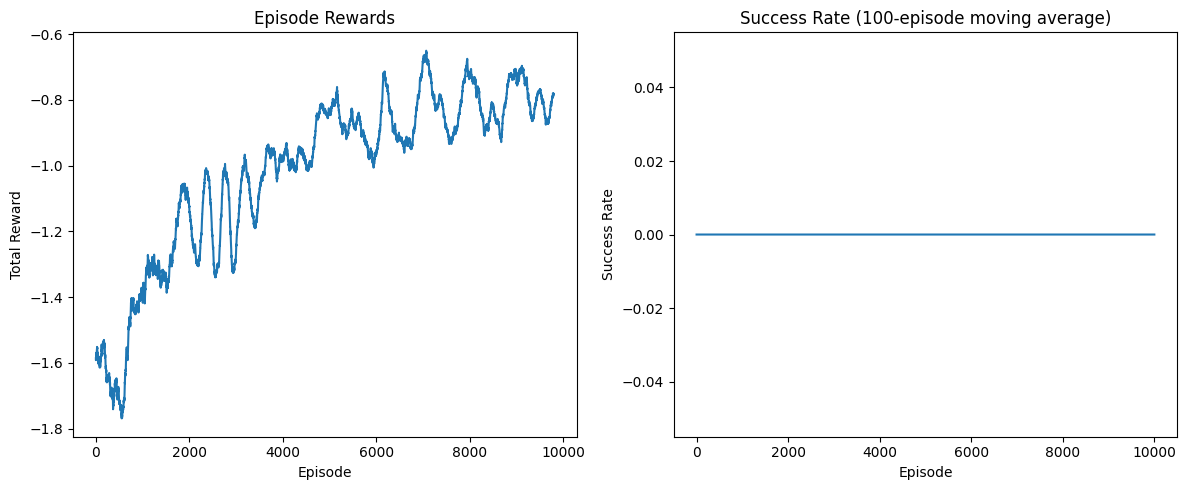

Training complete!
Visualizing the learned policy...

=== Test Episode 1 ===


2025-03-14 11:07:39.802 Python[45021:3415834] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/17/t6f3z0rd44jc522cqy2b5jzw0000gn/T/com.apple.python3.savedState


Step 1:
Agent 1: DOWN
Agent 2: RIGHT
Agent 3: UP
Reward: -0.001
Step 2:
Agent 1: DOWN
Agent 2: LEFT
Agent 3: LEFT
Reward: -0.001
Overlaps detected between agents: [(1, 2)]
Step 3:
Agent 1: UP
Agent 2: LEFT
Agent 3: DOWN
Reward: -0.001
Overlaps detected between agents: [(0, 2)]
Step 4:
Agent 1: DOWN
Agent 2: RIGHT
Agent 3: LEFT
Reward: -0.001
Step 5:
Agent 1: RIGHT
Agent 2: UP
Agent 3: DOWN
Reward: -0.001
Step 6:
Agent 1: DOWN
Agent 2: RIGHT
Agent 3: UP
Reward: -0.001
Step 7:
Agent 1: LEFT
Agent 2: DOWN
Agent 3: RIGHT
Reward: -5.0
Episode finished after 7 steps with total reward: -5.006
Failed. Agents fell into holes or couldn't reach the goal.

=== Test Episode 2 ===
Step 1:
Agent 1: DOWN
Agent 2: RIGHT
Agent 3: UP
Reward: -0.001


2025-03-14 11:07:44.927 Python[45021:3415834] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


Step 2:
Agent 1: DOWN
Agent 2: LEFT
Agent 3: LEFT
Reward: -0.001
Overlaps detected between agents: [(1, 2)]
Step 3:
Agent 1: UP
Agent 2: LEFT
Agent 3: DOWN
Reward: -0.001
Overlaps detected between agents: [(0, 2)]
Step 4:
Agent 1: DOWN
Agent 2: RIGHT
Agent 3: LEFT
Reward: -0.001
Step 5:
Agent 1: RIGHT
Agent 2: UP
Agent 3: DOWN
Reward: -0.001
Step 6:
Agent 1: DOWN
Agent 2: RIGHT
Agent 3: UP
Reward: -0.001
Step 7:
Agent 1: LEFT
Agent 2: DOWN
Agent 3: RIGHT
Reward: -5.0
Episode finished after 7 steps with total reward: -5.006
Failed. Agents fell into holes or couldn't reach the goal.

=== Test Episode 3 ===
Step 1:
Agent 1: DOWN
Agent 2: RIGHT
Agent 3: UP
Reward: -0.001
Step 2:
Agent 1: DOWN
Agent 2: LEFT
Agent 3: LEFT
Reward: -0.001
Overlaps detected between agents: [(1, 2)]
Step 3:
Agent 1: UP
Agent 2: LEFT
Agent 3: DOWN
Reward: -0.001
Overlaps detected between agents: [(0, 2)]
Step 4:
Agent 1: DOWN
Agent 2: RIGHT
Agent 3: LEFT
Reward: -0.001
Step 5:
Agent 1: RIGHT
Agent 2: UP
Agent 3: 

In [15]:
if __name__ == "__main__":
    print("Training the agents...")
    
    num_agent = 3
    
    n_ep            = 10000#0
    learning_rate   = 0.1
    discount_factor = 0.1
    explo_rate      = 1.0
    explo_decay     = 0.999#95
    min_explo_rate  = 0.05
    map_name        = '4x4'
    map_size        = 5
    seed            = 0
    
    map_ = createMap(num_agent, map_size, map_name, seed)
    
    trained_agent   = run_simulation(map_, num_agent, learning_rate, discount_factor, explo_rate, explo_decay, min_explo_rate, num_episodes=n_ep)
    print("Training complete!")
    # Compare policies
    # print("Comparing trained policy with random policy...")
    # compare_policies(trained_agent)
    
    # Visualize the learned policy
    print("Visualizing the learned policy...")
    visualize_policy(map_, trained_agent, num_episodes=3, num_agents=num_agent)